# Customer Churn Prediction

A Tour & Travels Company Wants To Predict Whether A Customer Will Churn Or Not Based On Indicators Given Below.
Predictive Model will be built using **Random Forest**.


In [6]:
# import necessary libraries
from sklearn import *
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Data Exploration

At this stage we will load the data and explore it. How many features do we have, what kind of data types, are there any missing values.

### Load the Data

It's important to determine, which variable is our dependent variable. 
In this case, our target variable is to be the one that indicates whether a customer has churned or not. 
So our dependent variable is "Target".

**Target = 1 - customer Churns, 0 - customer doesn't Churns**. 
  


In [7]:
original_data = pd.read_csv("Customertravel.csv")
print(original_data.head(10))
# print(len(original_data))

   Age FrequentFlyer AnnualIncomeClass  ServicesOpted  \
0   34            No     Middle Income              6   
1   34           Yes        Low Income              5   
2   37            No     Middle Income              3   
3   30            No     Middle Income              2   
4   30            No        Low Income              1   
5   27           Yes       High Income              1   
6   34            No     Middle Income              4   
7   34            No        Low Income              2   
8   30            No        Low Income              3   
9   36           Yes       High Income              1   

  AccountSyncedToSocialMedia BookedHotelOrNot  Target  
0                         No              Yes       0  
1                        Yes               No       1  
2                        Yes               No       0  
3                         No               No       0  
4                         No               No       0  
5                         No        

In [8]:
data_copy = original_data.copy(deep=True)
print(len(data_copy))
print(data_copy.head())

954
   Age FrequentFlyer AnnualIncomeClass  ServicesOpted  \
0   34            No     Middle Income              6   
1   34           Yes        Low Income              5   
2   37            No     Middle Income              3   
3   30            No     Middle Income              2   
4   30            No        Low Income              1   

  AccountSyncedToSocialMedia BookedHotelOrNot  Target  
0                         No              Yes       0  
1                        Yes               No       1  
2                        Yes               No       0  
3                         No               No       0  
4                         No               No       0  


### Check the Data

In [4]:
columns = list(data_copy.columns)
print(f"Columns: {columns}")
# len(data_copy.columns)
un= data_copy['AnnualIncomeClass'].unique()
print(un)


Columns: ['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted', 'AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Target']
['Middle Income' 'Low Income' 'High Income']


In [5]:
#check unique values of target
target_unique = data_copy["Target"].unique()
print(f"Target classes: {target_unique}")

class_counts = data_copy["Target"].value_counts()
print(class_counts)

Target classes: [0 1]
0    730
1    224
Name: Target, dtype: int64


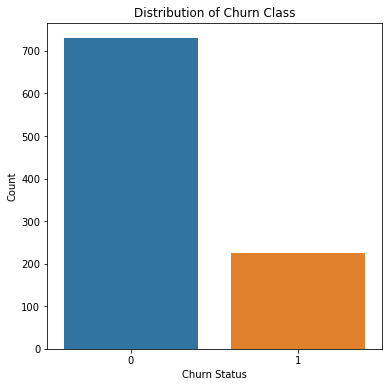

In [265]:
#plot the target values and see if there is disbalance

plt.figure(figsize=(6, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.title('Distribution of Churn Class')
plt.show()

We have class imbalance in our target variable. This indicates that Class 0 is the majority class, and Class 1 is the minority class. 
Class imbalance can potentially affect the performance of your machine learning model, especially if the model is biased towards predicting the majority class more frequently. We will use **class balance during the model training phase.** 

In [266]:
#check the data on missing or NAN values

data_copy.isnull().mean()
data_copy.dtypes

Age                            int64
FrequentFlyer                 object
AnnualIncomeClass             object
ServicesOpted                  int64
AccountSyncedToSocialMedia    object
BookedHotelOrNot              object
Target                         int64
dtype: object

### Data preprocessing 

 We have 4 object (categorical) variables, which we have to encode and convert them into numerical form.

In [267]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
print(data_copy.head())
# Encode 'FrequentFlyer' and 'AccountSyncedToSocialMedia'

data_copy['FrequentFlyer'] = label_encoder.fit_transform(data_copy['FrequentFlyer'])
data_copy['AccountSyncedToSocialMedia'] = label_encoder.fit_transform(data_copy['AccountSyncedToSocialMedia'])
data_copy['BookedHotelOrNot'] = label_encoder.fit_transform(data_copy['BookedHotelOrNot'])
#data_copy['AnnualIncomeClass'] = label_encoder.fit_transform(data_copy['AnnualIncomeClass'])
print(data_copy.head())

#one-hot encoded
# data_copy = pd.get_dummies(data_copy, columns=['AnnualIncomeClass'], drop_first=True, prefix='Income')
data_copy = pd.get_dummies(data_copy, columns=['AnnualIncomeClass'], drop_first=False, prefix='Income')
print(data_copy.head())


   Age FrequentFlyer AnnualIncomeClass  ServicesOpted  \
0   34            No     Middle Income              6   
1   34           Yes        Low Income              5   
2   37            No     Middle Income              3   
3   30            No     Middle Income              2   
4   30            No        Low Income              1   

  AccountSyncedToSocialMedia BookedHotelOrNot  Target  
0                         No              Yes       0  
1                        Yes               No       1  
2                        Yes               No       0  
3                         No               No       0  
4                         No               No       0  
   Age  FrequentFlyer AnnualIncomeClass  ServicesOpted  \
0   34              0     Middle Income              6   
1   34              2        Low Income              5   
2   37              0     Middle Income              3   
3   30              0     Middle Income              2   
4   30              0        Lo

In [268]:
print(data_copy.head())

   Age  FrequentFlyer  ServicesOpted  AccountSyncedToSocialMedia  \
0   34              0              6                           0   
1   34              2              5                           1   
2   37              0              3                           1   
3   30              0              2                           0   
4   30              0              1                           0   

   BookedHotelOrNot  Target  Income_High Income  Income_Low Income  \
0                 1       0                   0                  0   
1                 0       1                   0                  1   
2                 0       0                   0                  0   
3                 0       0                   0                  0   
4                 0       0                   0                  1   

   Income_Middle Income  
0                     1  
1                     0  
2                     1  
3                     1  
4                     0  


Because we'll be using Random Forest algorithm to solve our problem, we don't have to normalize our data.  Tree based algorithms are not sensitive to the scale of the input features. The Random forest algorithm works by making binary splits on individual features to build the trees, and these splits are based on the raw feature values rather than their scale.

### Data Splitting 

>**random_state = some_number** guarantees, that every time we run the code, we will get the same output,
which we made at the first time split.

In [269]:
x = data_copy.drop(columns=['Target'])
print(x.columns)
# print(len(x))
y = data_copy["Target"]
y.value_counts()
# print(len(y))

Index(['Age', 'FrequentFlyer', 'ServicesOpted', 'AccountSyncedToSocialMedia',
       'BookedHotelOrNot', 'Income_High Income', 'Income_Low Income',
       'Income_Middle Income'],
      dtype='object')


0    730
1    224
Name: Target, dtype: int64

In [270]:
from sklearn.model_selection import train_test_split


# Split the dataset into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Further split the training set into training and validation sets (90-10 split)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)


X_train, X_val, y_train, y_val = np.asarray(X_train), np.asarray(X_val), np.asarray(y_train), np.asarray(y_val)
X_test, y_test = np.asarray(X_test), np.asarray(y_test)
print(x)

     Age  FrequentFlyer  ServicesOpted  AccountSyncedToSocialMedia  \
0     34              0              6                           0   
1     34              2              5                           1   
2     37              0              3                           1   
3     30              0              2                           0   
4     30              0              1                           0   
..   ...            ...            ...                         ...   
949   31              2              1                           0   
950   30              0              5                           0   
951   37              0              4                           0   
952   30              0              1                           1   
953   31              2              1                           0   

     BookedHotelOrNot  Income_High Income  Income_Low Income  \
0                   1                   0                  0   
1                   0          

In [271]:
print(f"Training set: (X_train,y_train): {len(X_train),len(y_train)}, \nTest set: (X_test, y_test): {len(X_test), len(y_test)}")
print(f"Validation set: (X_val, y_val): {len(X_val), len(y_val)}")

Training set: (X_train,y_train): (686, 686), 
Test set: (X_test, y_test): (191, 191)
Validation set: (X_val, y_val): (77, 77)


In [272]:
#check the shape of each set

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(X_train)

X_train shape: (686, 8)
y_train shape: (686,)
X_val shape: (77, 8)
y_val shape: (77,)
X_test shape: (191, 8)
y_test shape: (191,)
[[29  2  1 ...  1  0  0]
 [27  2  1 ...  0  1  0]
 [31  0  2 ...  0  1  0]
 ...
 [28  0  3 ...  0  1  0]
 [30  0  1 ...  0  1  0]
 [28  2  1 ...  0  1  0]]


In [273]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


# Step 1: Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Step 2: Create an instance of the RandomForestClassifier
rf_model = RandomForestClassifier()

# Step 3: Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1', cv=5)

# Step 4: Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Step 5: Print the best hyperparameters and corresponding F1-score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

# Step 6: Create the final model with the best hyperparameters and train it on the combined training and validation data
best_rf_model = RandomForestClassifier(**grid_search.best_params_)
best_rf_model.fit(X_train, y_train)

# Step 7: Evaluate the final model on the test set
y_test_pred = best_rf_model.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred)
print("F1-score on Test Set:", test_f1_score)


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best F1-score: 0.7708068790137729
F1-score on Test Set: 0.6571428571428571


### Creat Random Forest Model

We will train **Random Forest Algorithm** on training set

In [274]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X = X_train
y = y_train

clf = RandomForestClassifier(n_estimators=50,max_depth=None,min_samples_leaf=1,min_samples_split=2)
clf = clf.fit(X,y)


In [275]:
y_predict_train = clf.predict(X_train)
print(f'Prediction on training set: {y_predict_train}')

Prediction on training set: [0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0
 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1
 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0
 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1

In [276]:
y_predict_val = clf.predict(X_val)
print(f'Prediction on validation set: {y_predict_val}')

Prediction on validation set: [0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0]


In [277]:
y_predict_test = clf.predict(X_test)
print(f'Prediction on test set: {y_predict_test}')

Prediction on test set: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0
 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 0 1]


In [278]:
#feature importance


# Get the feature importance scores from the trained model
feature_importances = clf.feature_importances_
print(feature_importances)

# Create a DataFrame to organize the feature names and their importance scores
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the importance scores
print(importance_df)

[0.30615269 0.14091292 0.23858308 0.10049887 0.05967571 0.07513597
 0.03271291 0.04632784]
                      Feature  Importance
0                         Age    0.306153
2               ServicesOpted    0.238583
1               FrequentFlyer    0.140913
3  AccountSyncedToSocialMedia    0.100499
5          Income_High Income    0.075136
4            BookedHotelOrNot    0.059676
7        Income_Middle Income    0.046328
6           Income_Low Income    0.032713


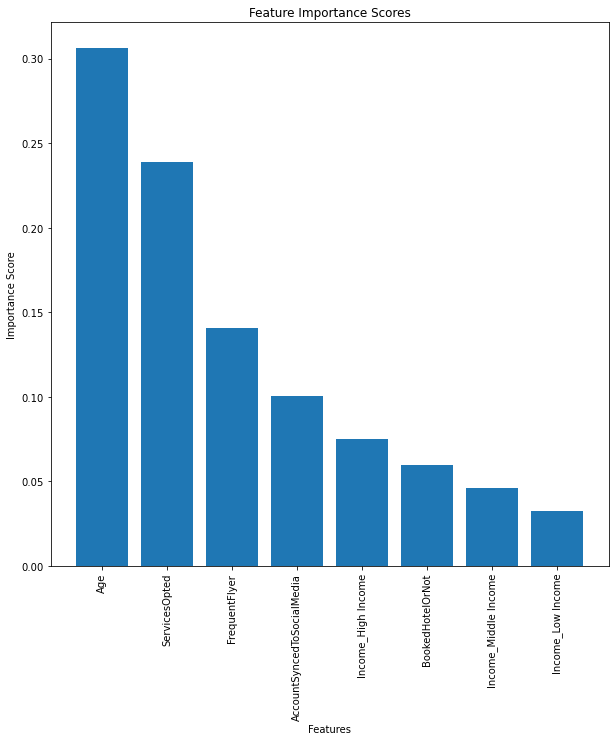

In [279]:
import matplotlib.pyplot as plt


plt.figure(figsize = (10,10))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance Scores')
plt.show()

#### Evaluate models performance

In [280]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

precision_train = precision_score(y_train, y_predict_train)
print(f'Precision_train: {precision_train}')

recall_train = recall_score(y_train, y_predict_train)
print(f'Recall_train: {recall_train}')

accuracy_train = accuracy_score(y_train, y_predict_train)
print(f'Accuracy_train: {accuracy_train}')

Precision_train: 0.8833333333333333
Recall_train: 0.9190751445086706
Accuracy_train: 0.9489795918367347


In [281]:
precision_val = precision_score(y_val, y_predict_val)
print(f'Precision_val: {precision_val}')

recall_val = recall_score(y_val, y_predict_val)
print(f'Recall_val: {recall_val}')

accuracy_val = accuracy_score(y_val, y_predict_val)
print(f'Accuracy_val: {accuracy_val}')

Precision_val: 0.65
Recall_val: 0.8125
Accuracy_val: 0.8701298701298701


In [282]:
precision_test = precision_score(y_test, y_predict_test)
print(f'Precision_test: {precision_test}')

recall_test = recall_score(y_test, y_predict_test)
print(f'Recall_test: {recall_test}')

accuracy_test = accuracy_score(y_test, y_predict_test)
print(f'Accuracy_test: {accuracy_test}')

Precision_test: 0.6486486486486487
Recall_test: 0.6857142857142857
Accuracy_test: 0.8743455497382199


In [283]:
from sklearn.metrics import f1_score, confusion_matrix

# Calculate F1-score for training, validation, and test sets

f1_train = f1_score(y_train, y_predict_train)
f1_val = f1_score(y_val, y_predict_val)
f1_test = f1_score(y_test, y_predict_test)

print(f'F1-score_train: {f1_train}')
print(f'F1-score_val: {f1_val}')
print(f'F1-score_test: {f1_test}')

# Confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_predict_test)
print('Confusion Matrix (Test Set):')
print(conf_matrix)

F1-score_train: 0.9008498583569405
F1-score_val: 0.7222222222222223
F1-score_test: 0.6666666666666667
Confusion Matrix (Test Set):
[[143  13]
 [ 11  24]]


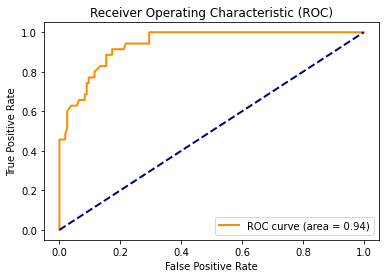

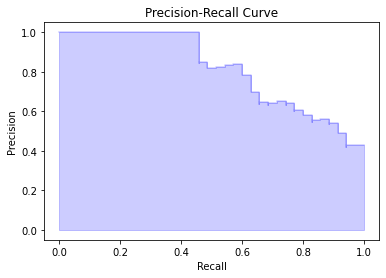

In [284]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC curve
probas = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probas[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, probas[:, 1])

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [285]:
best_threshold = 0
best_f1_score = 0
# print(probas)
#print(y_test)
# Loop through different threshold values
for threshold in np.arange(0.1, 1.0, 0.05):
    # Convert probabilities into binary predictions based on the current threshold
    y_pred_test = np.where(probas[:, 1] >= threshold, 1, 0)
    # Calculate the F1 score for the current threshold
    current_f1_score = f1_score(y_test, y_pred_test)
    
    # Update the best threshold and best F1 score if necessary
    if current_f1_score > best_f1_score:
        best_threshold = threshold
        best_f1_score = current_f1_score

print("Best Threshold:", best_threshold)
print("Best F1 Score on Test Set:", best_f1_score)

Best Threshold: 0.3500000000000001
Best F1 Score on Test Set: 0.7012987012987013


### K-Fold Stratified Cross-Validation 

K-Fold Stratified Cross-Validation is a variation of the standard K-Fold Cross-Validation technique that helps to preserve the class distribution in each fold, especially in cases of imbalanced datasets. It ensures that each fold has a similar proportion of samples from each class, which is important when dealing with classification tasks where the classes are not evenly distributed.

In [290]:
from sklearn.model_selection import StratifiedKFold


# Create an instance of the RandomForestClassifier with the best hyperparameters 
# (Best Hyperparameters we have already defined above)

rf_model = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1)

# Create a StratifiedKFold object with the desired number of folds (e.g., k=5)
# Set shuffle=True to randomize the data before splitting (optional)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Initialize lists to store evaluation scores for each fold
f1_scores = []
accuracy_scores = []
x_arr, y_arr = np.asarray(X), np.asarray(y)


# Perform stratified cross-validation
for train_index, test_index in stratified_kfold.split(x_arr, y_arr):
    X_train, X_test = x_arr[train_index], x_arr[test_index]
    y_train, y_test = y_arr[train_index], y_arr[test_index]
    #print(X_train)
    # print(len(X_train))
    
    # Train the model on the training data
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = rf_model.predict(X_test)
    
    # Calculate evaluation metrics (e.g., F1-score and accuracy) for the fold
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Print the evaluation scores for each fold
print("F1-scores for each fold:", f1_scores)
print("Accuracy scores for each fold:", accuracy_scores)

# Print the mean and standard deviation of the evaluation scores
print("Mean F1-score:", np.mean(f1_scores))
print("Mean Accuracy:", np.mean(accuracy_scores))
print("Standard Deviation of F1-scores:", np.std(f1_scores))
print("Standard Deviation of Accuracy scores:", np.std(accuracy_scores))


F1-scores for each fold: [0.732394366197183, 0.7536231884057971, 0.7647058823529412, 0.7894736842105263, 0.6440677966101694]
Accuracy scores for each fold: [0.8623188405797102, 0.8759124087591241, 0.8832116788321168, 0.8832116788321168, 0.8467153284671532]
Mean F1-score: 0.7368529835553235
Mean Accuracy: 0.8702739870940442
Standard Deviation of F1-scores: 0.049909782738046755
Standard Deviation of Accuracy scores: 0.01403463064177274
